# **NLP- Canva Reviews**

## Introduction

This notebook explores the application of Natural Language Processing (NLP) techniques to perform sentiment analysis on user reviews of the Canva application. Sentiment analysis is a crucial task in NLP, enabling businesses to gauge customer satisfaction and respond to feedback effectively.

The primary objective is to preprocess textual data, transforming it into a format suitable for machine learning models, and to build a binary classification model to predict whether a review is positive or negative. This notebook covers the following key areas:

1. **Data Exploration and Visualization:**
   - The dataset is loaded, and exploratory data analysis (EDA) is performed to understand the distribution and characteristics of the reviews. Visualization techniques are employed to gain insights into the data.

2. **Text Preprocessing:**
   - Text data in its raw form is often unstructured and noisy. A series of preprocessing steps, including tokenization, stopwords removal, punctuation removal, and stemming, are applied to clean and prepare the text for analysis.

3. **Feature Extraction:**
   - To convert text data into numerical representations that can be fed into machine learning models, various techniques such as Bag of Words, N-grams, and Term Frequency-Inverse Document Frequency (TF-IDF) are explored.

4. **Model Building:**
   - A Logistic Regression model is implemented to classify the sentiment of the reviews. The model is trained and evaluated on the preprocessed data, with performance metrics such as accuracy, precision, and recall used to assess its effectiveness.

5. **Predictions on New Data:**
   - The trained model is then applied to new, unseen reviews to predict their sentiment, demonstrating the model's ability to generalize beyond the training data.


## Dataset

The dataset consists of over a thousand user reviews of the Canva application. Each review is labeled with a sentiment indicating whether it is positive or negative. Additional features provide metadata about the review, such as the user who wrote it, the version of the application being reviewed, and the timestamp of the review. This dataset provides a rich source of text data for NLP processing and sentiment analysis.

### Data Dictionary

| Column                   | Description                                                                 |
| -------------------------| --------------------------------------------------------------------------- |
| **reviewId**              | Unique identifier for each review.                                          |
| **userName**              | The name of the user who submitted the review.                              |
| **userImage**             | URL of the user's profile image.                                            |
| **review**                | The text content of the review.                                             |
| **score**                 | Rating score given by the user (e.g., 1 to 5 stars).                        |
| **thumbsUpCount**         | Number of users who found the review helpful.                               |
| **reviewCreatedVersion**  | The version of the application at the time the review was written.          |
| **at**                    | Timestamp of when the review was written.                                   |
| **replyContent**          | The content of the reply from Canva to the review (if any).                 |
| **repliedAt**             | Timestamp of when the reply was made by Canva.                              |
| **Sentiment**             | Sentiment label indicating whether the review is positive or negative.      |
| **Sub Category**          | Category to which the review belongs (if applicable).                       |
| **Sub Category_test**     | Test category for validation purposes (if applicable).                      |

---


In [1]:
# Mount Google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [36]:
# Import necessary libraries and packages
import pickle
import pandas as pd
import numpy as np

from collections import Counter

import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, LancasterStemmer
from nltk.tokenize import sent_tokenize, word_tokenize, RegexpTokenizer
nltk.download('punkt')
nltk.download('stopwords')

from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [3]:
# Load in the dataset
df= pd.read_excel('/content/drive/My Drive/Canva_reviews.xlsx')

# View the dataset
df.head()

,reviewId,userName,userImage,review,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt,Sentiment,Sub Category,Sub Category_test
0,gp:AOqpTOFxf3fttcT5DSvFIn9KPp5FErgH9yC533Fmoxv...,Donna Caritero,https://play-lh.googleusercontent.com/a-/AOh14...,Overall it's really an amazing app. I've been ...,4,528,2.116.0,2021-06-17 07:18:54,Hi Donna. We are sorry that your text or desig...,2021-06-19 21:24:32,Negative,NaN,bug_picture_quality
1,gp:AOqpTOEq6rNIWLnPV4KFTctWvm0mpGEQljtD6mvy1H-...,Soumi Mukhopadhyay,https://play-lh.googleusercontent.com/a-/AOh14...,Hey! Yes I gave a 5 star rating... coz I belie...,5,351,2.116.0,2021-06-17 19:18:28,NaN,NaT,Positive,extremely_happy,NaN
2,gp:AOqpTOE86hSyPRHZgYt28Uk5zGe4FZGb1hkmtFDiYJ2...,Theknown _unknown,https://play-lh.googleusercontent.com/a-/AOh14...,Canva used to be a good app! But recently I've...,1,160,2.116.0,2021-06-23 19:13:28,Hi there. We're sorry to hear that you are hav...,2021-06-26 20:20:56,Negative,saving_downloading_issue,bug_saving_files
3,gp:AOqpTOHSuKkVTcM3QgCCKysHQlxEnk2ocOKsUMiMIJy...,Anthony Dean,https://play-lh.googleusercontent.com/a/AATXAJ...,"It's a brilliant app, but I have just one prob...",5,145,2.116.0,2021-06-19 23:36:07,NaN,NaT,Negative,others,bug_app_crash
4,gp:AOqpTOEOrZt5H6jXPiplJyffCd5ZBnVXACTWgwNsF1R...,Neha Diana Wesley,https://play-lh.googleusercontent.com/a-/AOh14...,This was such a great app. I used to make BTS ...,4,142,2.116.0,2021-06-21 00:29:27,Hi Neha. Sorry to hear that you are unable to ...,2021-06-24 20:46:28,Negative,others,bug_other


In [4]:
# View the columns
df.columns

Index(['reviewId', 'userName', 'userImage', 'review', 'score', 'thumbsUpCount',
       'reviewCreatedVersion', 'at', 'replyContent', 'repliedAt', 'Sentiment',
       'Sub Category', 'Sub Category_test'],
      dtype='object')

In [5]:
# Rewriting columns names in snake_case format
df.columns= [
    'review_id',
    'user_name',
    'user_image',
    'review',
    'score',
    'thumbs_up_count',
    'review_created_version',
    'at',
    'reply_content',
    'replied_at',
    'sentiment',
    'sub_category',
    'sub_category_test'
]

# Verify changes
df.columns

Index(['review_id', 'user_name', 'user_image', 'review', 'score',
       'thumbs_up_count', 'review_created_version', 'at', 'reply_content',
       'replied_at', 'sentiment', 'sub_category', 'sub_category_test'],
      dtype='object')

In [6]:
# Explore the data
df.shape

(1500, 13)

In [7]:
# Explore the datatypes
df.dtypes

,0
review_id,object
user_name,object
user_image,object
review,object
score,int64
thumbs_up_count,int64
review_created_version,object
at,datetime64[ns]
reply_content,object
replied_at,datetime64[ns]


In [8]:
# Extracting and inspecting the review and sentiment at index 13 and index 1495
review_13= df.loc[13, 'review']
sentiment_13= df.loc[13, 'sentiment']
review_1495= df.loc[1495, 'review']
sentiment_1495= df.loc[1495, 'sentiment']

# Display extracted reviews and corresponding sentiments
(review_13, sentiment_13), (review_1495, sentiment_1495)

(('Unable to save my work. Nothing works :(', 'Negative'),
 ('Absolutely amazing and a lifesaver for teachers.', 'Positive'))

### Inspecting Specific Reviews

To gain a better understanding of how reviews correlate with their sentiment labels, two specific reviews were manually inspected. The review at index 13, "Unable to save my work. Nothing works :(", is labeled as 'Negative', while the review at index 1495, "Absolutely amazing and a lifesaver for teachers.", is labeled as 'Positive'. This inspection helps validate that the sentiment labels align with the review content, ensuring the dataset's reliability for further analysis.


<ipython-input-9-669f2dd4f20d>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax= sns.barplot(x= sentiment_counts.index, y= sentiment_counts.values, palette= 'viridis', width= 0.5)


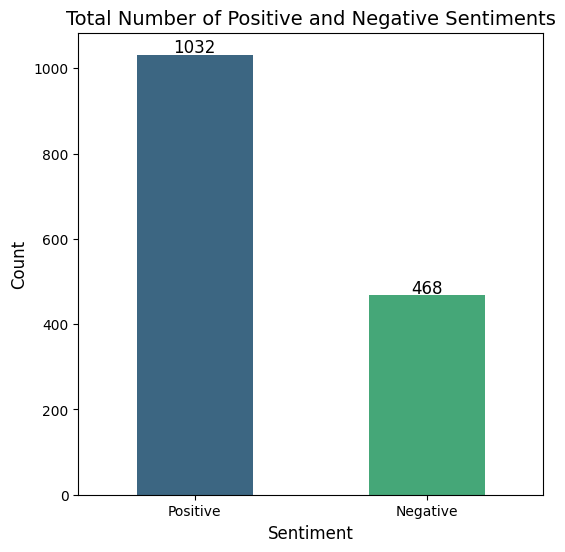

In [9]:
# Checking total number of 'Positive' and 'Negative' sentiments
sentiment_counts= df['sentiment'].value_counts()

# Plot the sentiment distribution
plt.figure(figsize= (6,6))
ax= sns.barplot(x= sentiment_counts.index, y= sentiment_counts.values, palette= 'viridis', width= 0.5)

# Dispaly the count on top of the bars
for p in ax.patches:
  ax.annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2., p.get_height()),
              ha= 'center', va= 'center', xytext= (0,5), textcoords= 'offset points', fontsize= 12)

# Add labels
plt.xlabel('Sentiment', fontsize= 12)
plt.ylabel('Count', fontsize= 12)
plt.title('Total Number of Positive and Negative Sentiments', fontsize= 14)
plt.show()

### Sentiment Distribution Analysis

The bar plot illustrates the distribution of positive and negative sentiments among the user reviews:

- **Positive Sentiments:** There are 1,032 positive reviews, which constitute the majority of the dataset.
- **Negative Sentiments:** There are 468 negative reviews, which are significantly fewer than positive reviews.

This distribution indicates that the overall sentiment towards the Canva application is predominantly positive, with more than twice as many positive reviews as negative ones. This could suggest a generally favorable user experience, though the presence of nearly 500 negative reviews still highlights areas where user satisfaction might be improved.


In [11]:
# Calculate percentage of the sentiments
sentiment_pct= df['sentiment'].value_counts(normalize= True) * 100

# View percentages
sentiment_pct

,proportion
sentiment,
Positive,68.8
Negative,31.2


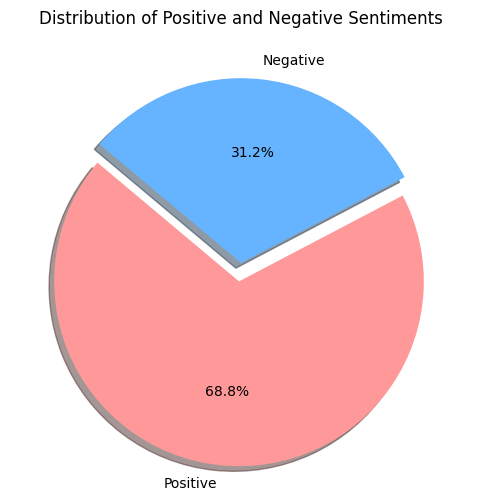

In [13]:
# Pie chart with sentiment percentages
plt.figure(figsize= (6,6))
plt.pie(sentiment_pct, labels= sentiment_pct.index, autopct= '%1.1f%%', startangle= 140, colors= ['#ff9999','#66b3ff'],
        explode= (0.1,0), shadow= True)
plt.title('Distribution of Positive and Negative Sentiments')
plt.show()

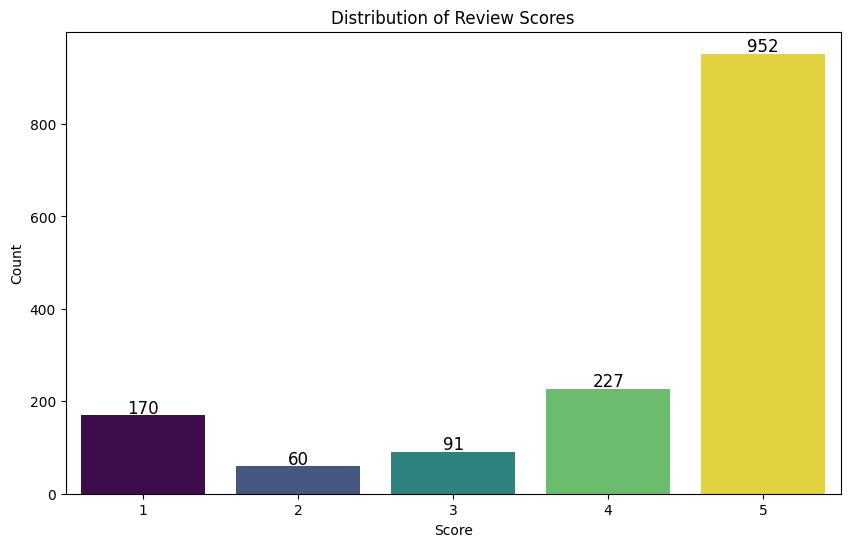

In [17]:
# Plot the 'score' feature
plt.figure(figsize= (10,6))
ax= sns.countplot(data= df, x= 'score', hue= 'score', palette= 'viridis', legend= False)

# Add count labels on top of the bars
for p in ax.patches:
  ax.annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2., p.get_height()),
              ha= 'center', va= 'center', xytext= (0,5), textcoords= 'offset points', fontsize= 12)

# Add labels
plt.xlabel('Score')
plt.ylabel('Count')
plt.title('Distribution of Review Scores')
plt.show()

### Review Scores Distribution Analysis

The bar plot illustrates the distribution of review scores provided by users:

- **Score 5:** The majority of users (952 reviews) gave the highest score of 5, indicating a high level of satisfaction with the Canva application.
- **Score 4:** A smaller but still significant number of users (227 reviews) rated the application with a score of 4.
- **Score 3:** There are 91 reviews with a score of 3, suggesting a more neutral or mixed sentiment.
- **Score 2:** Only 60 reviews gave a score of 2, indicating dissatisfaction but not the lowest possible score.
- **Score 1:** There are 170 reviews with the lowest score of 1, reflecting a significant number of highly dissatisfied users.

This distribution indicates that the overall user experience is generally positive, with the majority of reviews giving high scores (4 and 5). However, the presence of lower scores (1 and 2) highlights that there is a notable segment of users who are not satisfied with their experience.


In [18]:
# Percentages of the scores
score_pct= df['score'].value_counts(normalize= True) * 100
score_pct

,proportion
score,
5,63.466667
4,15.133333
1,11.333333
3,6.066667
2,4.000000


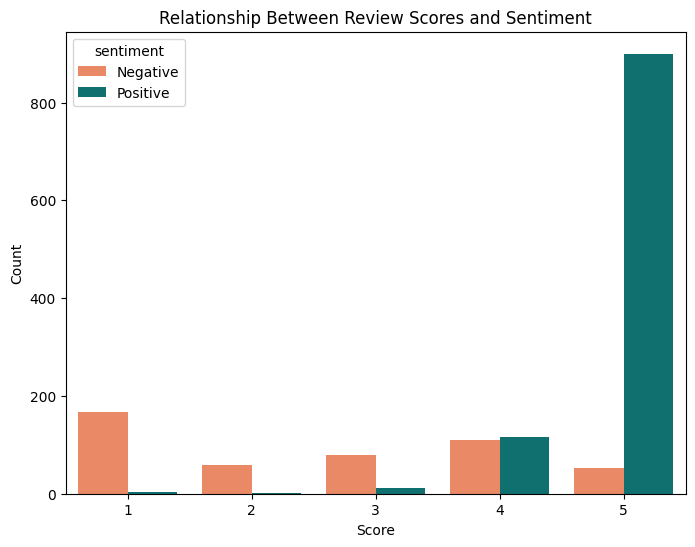

In [22]:
# Plot relationship between the 'score' and 'sentiment' features
plt.figure(figsize= (8,6))
ax= sns.countplot(data= df, x= 'score', hue= 'sentiment', palette= {'Positive': 'teal', 'Negative': 'coral'})
plt.xlabel('Score')
plt.ylabel('Count')
plt.title('Relationship Between Review Scores and Sentiment')
plt.show()

### Relationship Between Review Scores and Sentiment

The bar plot illustrates the relationship between review scores and the corresponding sentiments (positive and negative):

- **Score 1:** The majority of reviews with a score of 1 are associated with negative sentiments, indicating strong dissatisfaction among these users.
- **Score 2:** Reviews with a score of 2 are predominantly negative, although they represent a smaller portion of the total reviews.
- **Score 3:** Reviews with a score of 3 are mostly negative, suggesting a trend where neutral or slightly negative experiences are more common at this mid-level score.
- **Score 4:** Reviews with a score of 4 show a more balanced distribution between positive and negative sentiments, with a slight lean towards positive.
- **Score 5:** The overwhelming majority of reviews with a score of 5 are positive, highlighting that users who rate the application highly are generally very satisfied.

This distribution clearly indicates that higher scores are strongly associated with positive sentiments, while lower scores are linked with negative sentiments. The presence of some negative sentiment even at higher scores (4 and 5) suggests that while most users are satisfied, there are still some concerns or issues that affect even those who rate the application positively.


In [23]:
# Adding new column 'len' to store the length of each review
df['len']= df['review'].apply(len)

# Display descriptive statistics of the 'len' column
df['len'].describe()

,len
count,1500.000000
mean,86.468667
std,55.681355
min,20.000000
25%,54.000000
50%,75.000000
75%,102.000000
max,498.000000


### Review Length Analysis

The distribution of review lengths (measured in characters) provides insight into the nature of the feedback provided by users:

- **Count:** 1,500 reviews were analyzed.
- **Mean:** The average review length is approximately 86 characters.
- **Standard Deviation:** The standard deviation is around 56 characters, indicating variability in review lengths.
- **Minimum:** The shortest review is 20 characters long.
- **25th Percentile (Q1):** 25% of the reviews are 54 characters or shorter.
- **Median (Q2):** The median review length is 75 characters.
- **75th Percentile (Q3):** 75% of the reviews are 102 characters or shorter.
- **Maximum:** The longest review is 498 characters.

These statistics show that while most reviews are relatively short, there is a significant range in their lengths, with some users providing very detailed feedback.


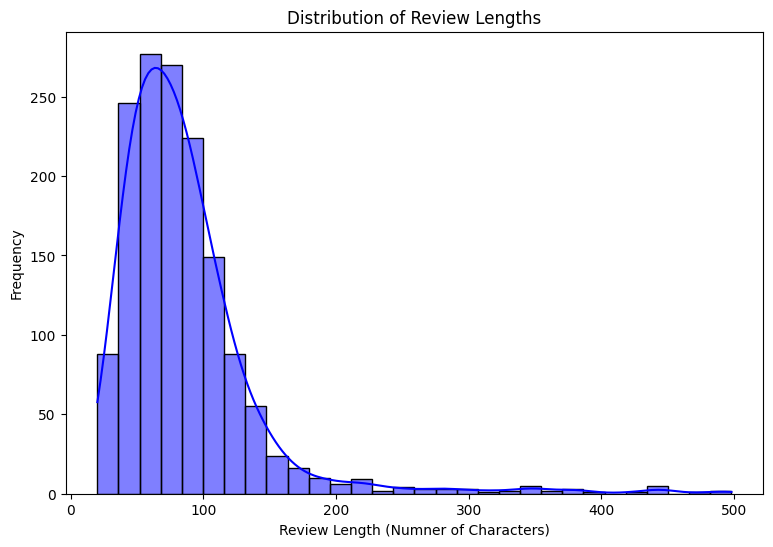

In [24]:
# 'len' histogram plot
plt.figure(figsize= (9,6))
sns.histplot(df['len'], bins= 30, kde= True, color= 'blue')
plt.xlabel('Review Length (Numner of Characters)')
plt.ylabel('Frequency')
plt.title('Distribution of Review Lengths')
plt.show()

### Distribution of Review Lengths

The histogram visualizes the distribution of review lengths in terms of the number of characters:

- **Central Tendency:** The majority of the reviews are relatively short, with the most common length ranging between 50 to 100 characters.
- **Skewness:** The distribution is right-skewed, indicating that while most reviews are short, there are a few much longer reviews, with some extending up to nearly 500 characters.
- **Frequency:** The peak frequency occurs around 80-100 characters, where the highest concentration of review lengths is observed.

This distribution suggests that most users tend to write concise reviews, but there are outliers who provide more detailed feedback. The presence of longer reviews, though infrequent, might contain more in-depth or elaborate opinions about the Canva application.


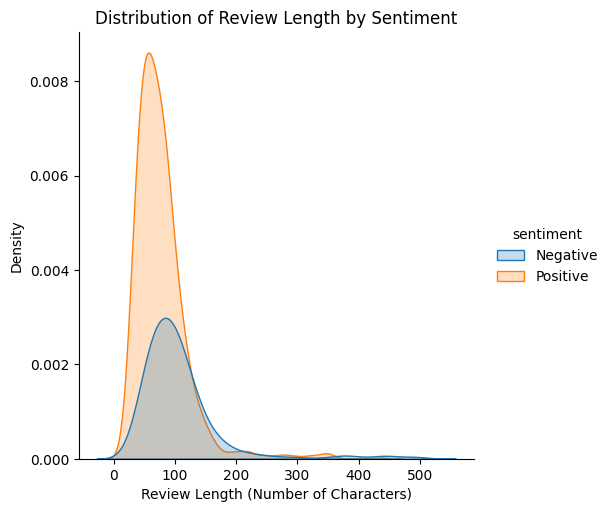

In [27]:
# Plot distribution of 'len' for different sentiment types
sns.displot(data= df, x= 'len', hue= 'sentiment', kind= 'kde', fill= True)
plt.xlabel('Review Length (Number of Characters)')
plt.ylabel('Density')
plt.title('Distribution of Review Length by Sentiment')
plt.show()

### Distribution of Review Lengths by Sentiment

The KDE plot visualizes the distribution of review lengths based on sentiment (positive or negative):

- **Positive Sentiments:** Reviews associated with positive sentiments generally tend to be shorter, with a peak around 60-80 characters. This suggests that users who have a positive experience tend to leave brief and concise feedback.
- **Negative Sentiments:** Reviews associated with negative sentiments also show a similar trend, but with a slightly broader distribution. There are some longer reviews within the negative sentiment group, indicating that dissatisfied users might provide more detailed feedback.

While both positive and negative reviews are mostly concise, there is a noticeable overlap. However, negative reviews show a tendency toward a wider range of lengths, including some significantly longer reviews, possibly reflecting more detailed complaints or concerns.


### Tokenization in Natural Language Processing (NLP)

**Tokenization** is a fundamental step in Natural Language Processing (NLP) that involves breaking down text into smaller, more manageable pieces called tokens. These tokens can be sentences, words, or even subwords depending on the level of granularity required for the analysis. Tokenization is crucial for several reasons:

1. **Text Simplification:**
   - Tokenization converts complex text data into simpler units (tokens) that are easier to analyze and manipulate. By breaking text into sentences or words, it becomes more structured and suitable for computational processing.

2. **Foundation for Further Processing:**
   - Tokenization is often the first step in text preprocessing. Once the text is tokenized, further operations like stemming, lemmatization, stopword removal, and feature extraction can be performed on these tokens.

3. **Contextual Analysis:**
   - Sentence tokenization allows for the analysis of text at the sentence level, which is essential in tasks like sentiment analysis, where the sentiment of each sentence may vary within a review or document.
   - Word tokenization breaks the text into individual words, which can then be used to build vocabulary, calculate word frequencies, or as inputs for machine learning models.

4. **Handling Large Text Data:**
   - Tokenization enables the handling of large and unstructured text data by breaking it into smaller chunks that can be processed more efficiently by NLP algorithms.

5. **Preparation for Modeling:**
   - Most NLP models, such as Bag of Words, TF-IDF, or neural networks like LSTMs and Transformers, require text to be tokenized before they can be fed into the model. Tokenization ensures that the text is in a format suitable for these algorithms to understand and learn from.

Tokenization is applied here to break down user reviews into sentences and words, enabling a more granular analysis of the text. This process is essential for understanding the structure of the reviews and preparing the data for subsequent NLP tasks, such as sentiment analysis or text classification.


In [33]:
# Focusing on text data and its sentiment by selecting only the 'review' and 'sentiment' columns for tokenization
df_reviews= df[['review', 'sentiment']]

# View review at index 13 to understand its contents before tokenization
review_13= df.loc[13, 'review']
print('Review at index 13:', review_13)

# Sentence tokenization of the review at index 13
sentences_13= sent_tokenize(review_13)
print('Sentence Tokenization (index 13):', sentences_13)

# View another review
review_1495= df.loc[1495, 'review']
print('Review at index 1495:', review_1495)

# Sentence tokenization of the review at index 1495
sentences_1495= sent_tokenize(review_1495)
print('Sentence Tokenization (index 1495):', sentences_1495)

# Word tokenization of the review at index 13
words_13= word_tokenize(review_13)
print('Word Tokenization (index 13):', words_13)

# Word tokenization of the reviews at index 1495
words_1495= word_tokenize(review_1495)
print('Word Tokenization (index 1495):', words_1495)

Review at index 13: Unable to save my work. Nothing works :(
Sentence Tokenization (index 13): ['Unable to save my work.', 'Nothing works :(']
Review at index 1495: Absolutely amazing and a lifesaver for teachers.
Sentence Tokenization (index 1495): ['Absolutely amazing and a lifesaver for teachers.']
Word Tokenization (index 13): ['Unable', 'to', 'save', 'my', 'work', '.', 'Nothing', 'works', ':', '(']
Word Tokenization (index 1495): ['Absolutely', 'amazing', 'and', 'a', 'lifesaver', 'for', 'teachers', '.']


### Text Preprocessing: Lowercasing and Tokenization

**Lowercasing** is an essential preprocessing step in Natural Language Processing (NLP) that involves converting all characters in the text to lowercase. This normalization step ensures that words like "Word" and "word" are treated as the same token, reducing the number of distinct tokens and thus simplifying the analysis.

After lowercasing, **tokenization** is applied, which involves breaking the text into individual words (tokens). These tokens are the fundamental building blocks for further text processing tasks, such as frequency analysis, stopword removal, and feeding text data into machine learning models.

By converting all text to lowercase and tokenizing it into words, the text data becomes more uniform and structured, making it easier to analyze and model.


In [34]:
# Convert the 'review' column to a list of strings
reviews= list(df_reviews['review'])

# Check the number of reviews in the dataset
num_reviews= len(reviews)
print('Number of reviews:', num_reviews)

# View specific reviews before converting to lowercase
print('Review at index 13:', reviews[13])
print('Review at index 1495:', reviews[1495])

# Converting a specific review to lowercase
print('Review at index 1495 in lowercase:', reviews[1495].lower())

# Converting all reviews to lowercase using list comprehension
reviews_lower= [r.lower() for r in reviews]
print('Review at index 13 in lowercase:', reviews_lower[13])

# Tokenizing each review into words
tokens= [word_tokenize(r) for r in reviews_lower]

# Viewing the tokenized output of specific reviews
print('Tokenized words at index 13:', tokens[13])
print('Tokenized words at index 1495:', tokens[1495])

# Checking the number of tokenized reviews
num_tokens= len(tokens)
print('Number of Tokenized Reviews:', num_tokens)

Number of reviews: 1500
Review at index 13: Unable to save my work. Nothing works :(
Review at index 1495: Absolutely amazing and a lifesaver for teachers.
Review at index 1495 in lowercase: absolutely amazing and a lifesaver for teachers.
Review at index 13 in lowercase: unable to save my work. nothing works :(
Tokenized words at index 13: ['unable', 'to', 'save', 'my', 'work', '.', 'nothing', 'works', ':', '(']
Tokenized words at index 1495: ['absolutely', 'amazing', 'and', 'a', 'lifesaver', 'for', 'teachers', '.']
Number of Tokenized Reviews: 1500


### Stopwords Removal in NLP

**Stopwords** are common words in a language that typically carry little semantic meaning, such as "and," "the," "is," and "in." These words are often removed during text preprocessing in Natural Language Processing (NLP) because they occur frequently and can add noise to the analysis without contributing significant value.

#### Importance of Stopwords Removal

1. **Reducing Noise:**
   - Stopwords can clutter the text data, making it harder to focus on the more meaningful words that convey the key information or sentiment. By removing stopwords, the dataset becomes cleaner and more focused on the content that matters.

2. **Improving Model Performance:**
   - Removing stopwords can lead to better model performance by reducing the dimensionality of the text data. This makes it easier for machine learning models to identify patterns and relationships between words, leading to more accurate predictions.

3. **Efficiency:**
   - Processing and analyzing text without stopwords is generally more efficient, as it reduces the number of words that need to be handled, stored, and analyzed.

In this step, stopwords will be removed from the tokenized text to ensure that only the most relevant words are kept for further analysis.


In [37]:
# Get the list of English stopwords
sw= stopwords.words('english')

# Display the first 10 stopwords for reference
print('First 10 stopwords:', sw[:10])

# Remove stopwords from the tokenized words
tokens= [[word for word in t if word not in sw] for t in tokens]

# Inspect the results after stopwords removal
print('Original review at index 13:', reviews[13])
print('Tokens at index 13 after stopwords removal:', tokens[13])
print('Original review at index 1495:', reviews[1495])
print('Tokens at index 1495 after stopwards removal:', tokens[1495])

First 10 stopwords: ['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're"]
Original review at index 13: Unable to save my work. Nothing works :(
Tokens at index 13 after stopwords removal: ['unable', 'save', 'work', '.', 'nothing', 'works', ':', '(']
Original review at index 1495: Absolutely amazing and a lifesaver for teachers.
Tokens at index 1495 after stopwards removal: ['absolutely', 'amazing', 'lifesaver', 'teachers', '.']


### Punctuation Removal in NLP

**Punctuation Removal** is a common preprocessing step in Natural Language Processing (NLP) that involves stripping away punctuation marks like periods, commas, exclamation points, and others from text. The main reasons for removing punctuation are:

1. **Simplification of Text:**
   - Punctuation marks often do not contribute to the semantic meaning of words and can add noise to the data. By removing them, the text becomes simpler and more uniform.

2. **Consistency in Tokenization:**
   - Punctuation can create inconsistencies in tokenization, such as treating "word," and "word" as different tokens. Removing punctuation helps in treating all variations of a word as a single token.

3. **Improving Model Performance:**
   - Models typically perform better on clean and consistent data. Removing punctuation reduces the variability in the text, allowing models to focus on the words and their meanings rather than on punctuation.

In this step, punctuation will be removed from the tokenized words to further clean the text data and prepare it for analysis.


In [38]:
# Create a tokenizer that removes punctuation
tokenizer= RegexpTokenizer(r'\w+')

# Example: Tokenizing a word with punctuation
example_tokenization= tokenizer.tokenize("wasn't")
print("Tokenization of \"wasn't\":", example_tokenization)

# Example: Joining the tokens back together
joined_example= "".join(example_tokenization)
print('Joined tokenization:', joined_example)

# Remove the punctuation from the tokenized words
tokens= [["".join(tokenizer.tokenize(word)) for word in t if len(tokenizer.tokenize(word)) > 0] for t in tokens]

# Inspect the results after punctuation removal
print('Original review at index 13:', reviews[13])
print('Tokens at index 13 after punctuation removal:', tokens[13])
print('Original review at index 1495:', reviews[1495])
print('Tokens at index 13 after punctuation removal:', tokens[1495])

Tokenization of "wasn't": ['wasn', 't']
Joined tokenization: wasnt
Original review at index 13: Unable to save my work. Nothing works :(
Tokens at index 13 after punctuation removal: ['unable', 'save', 'work', 'nothing', 'works']
Original review at index 1495: Absolutely amazing and a lifesaver for teachers.
Tokens at index 13 after punctuation removal: ['absolutely', 'amazing', 'lifesaver', 'teachers']


### Stemming in Natural Language Processing (NLP)

**Stemming** is a text preprocessing technique in Natural Language Processing (NLP) that reduces words to their root form or base form. The idea is to strip suffixes like "ing," "ed," "s," etc., to obtain the core part of the word, known as the "stem." For example, "running," "runner," and "ran" would all be reduced to "run."

#### Importance of Stemming

1. **Reducing Vocabulary Size:**
   - By reducing words to their root forms, stemming helps in decreasing the number of unique words in the text. This reduction in vocabulary size simplifies the data and makes it more manageable for machine learning models.

2. **Improving Search and Matching:**
   - Stemming ensures that variations of a word (e.g., "connect," "connected," "connection") are treated as the same word, which is crucial in search algorithms and matching processes. This improves the consistency of text data.

3. **Efficiency in Text Processing:**
   - Stemming reduces the complexity of text data, making it easier and faster to process. This is particularly useful when dealing with large datasets or when computational resources are limited.

In this step, stemming will be applied to the tokenized words to further normalize the text data by reducing words to their root forms.


In [39]:
# Initialize the Porter and Lancaster stemmers
porter= PorterStemmer()
lancaster= LancasterStemmer()

# Example of stemming with both stemmers
print('Porter Stemmer- "teachers":', porter.stem('teachers'))
print('Lancaster Stemmer- "teachers":', lancaster.stem('teachers'))

# Apply stemming to all tokens using the Porter Stemmer
tokens= [[porter.stem(word) for word in t] for t in tokens]

# Inspect the results after stemming
print('Original review at index 13', reviews[13])
print('Tokens at index 13 after stemming:', tokens[13])
print('Original review at index 1495:', reviews[1495])
print('Tokens at index 1495 after stemming:', tokens[1495])

Porter Stemmer- "teachers": teacher
Lancaster Stemmer- "teachers": teach
Original review at index 13 Unable to save my work. Nothing works :(
Tokens at index 13 after stemming: ['unabl', 'save', 'work', 'noth', 'work']
Original review at index 1495: Absolutely amazing and a lifesaver for teachers.
Tokens at index 1495 after stemming: ['absolut', 'amaz', 'lifesav', 'teacher']


### Word Count Distribution in NLP

**Word Count Distribution** refers to the process of counting how frequently each word appears in a text dataset. This is an essential step in understanding the overall structure and patterns within the text data. By analyzing the distribution of word counts, we can identify which words are most common, which may carry significant meaning or represent key themes in the text.

#### Importance of Word Count Distribution

1. **Identifying Key Terms:**
   - By examining the most common words in a dataset, we can identify the key terms that are central to the text. These terms often reflect the primary topics or sentiments expressed in the data.

2. **Feature Selection:**
   - In NLP tasks, frequent words might be used as features for models. Understanding the distribution helps in selecting which words to include as features and which to ignore.

3. **Data Understanding:**
   - Word count distribution provides insights into the data, such as the presence of stopwords, the frequency of specific terms, or the need for further preprocessing steps like removing rare words.

4. **Modeling Insights:**
   - Knowing the word count distribution can inform decisions about weighting words (e.g., using TF-IDF) in a way that accounts for their frequency across the dataset, leading to more effective modeling.

In this step, the distribution of word counts will be analyzed to identify the most common words and understand their impact on the dataset.


In [40]:
# Flatten the list of tokens to create a single list of all words
flat_tokens= [word for t in tokens for word in t]

# Check the total number of words after flattening
total_words= len(flat_tokens)
print('Total number of words:', total_words)

# Display the first 10 tokens for reference
print('First 10 tokens:', flat_tokens[:10])

# Count the frequency of each word in the dataset
counts= Counter(flat_tokens)

# Check the number of unique words (vocabulary size)
unique_words= len(counts)
print('Number of unique words:', unique_words)

# Display the 10 most common words
most_common_words= counts.most_common(10)
print('10 most common words:', most_common_words)

Total number of words: 13782
First 10 tokens: ['overal', 's', 'realli', 'amaz', 'app', 've', 'use', 'past', '5', 'year']
Number of unique words: 1720
10 most common words: [('app', 932), ('use', 474), ('design', 349), ('easi', 293), ('s', 240), ('love', 220), ('good', 219), ('edit', 191), ('make', 190), ('great', 184)]


### Word Count Distribution Analysis

After analyzing the word count distribution in the dataset, the following insights were obtained:

1. **Total Number of Words: 13,782**
   - This is the total count of all words (tokens) across all reviews after preprocessing steps such as stemming and stopwords removal.

2. **First 10 Tokens:**
   - The first 10 tokens provide a snapshot of the content in the dataset. Words like "overal," "amaz," and "app" suggest that the reviews frequently describe general impressions and the application's functionality.

3. **Number of Unique Words: 1,720**
   - The vocabulary size, after preprocessing, consists of 1,720 unique words. This reflects the diversity of words used in the reviews, despite stemming and stopwords removal.

4. **10 Most Common Words:**
   - **'app' (932 occurrences):** Indicates that the application itself is a primary focus in most reviews.
   - **'use' (474 occurrences):** Reflects that many users discuss their experience of using the app.
   - **'design' (349 occurrences):** Suggests that design is a significant aspect mentioned by users.
   - **'easi' (293 occurrences):** Likely indicates user sentiment about the ease of use.
   - **'love' (220 occurrences):** Points to a generally positive sentiment in the reviews.
   - **Other common words:** such as 'good,' 'edit,' 'make,' and 'great' also indicate that functionality, user experience, and overall satisfaction are key themes in the reviews.

### Insights:
- The frequent use of words like "app," "use," "design," and "love" suggests that users are primarily focused on the application's usability and design features, with a generally positive sentiment.
- This distribution of words provides a strong foundation for further analysis, such as sentiment analysis or feature extraction, by highlighting the core vocabulary that represents user experiences and sentiments in the dataset.



### Bag of Words (BoW) in NLP

**Bag of Words (BoW)** is a fundamental text representation technique used in Natural Language Processing (NLP) that converts text into a fixed-length vector of numbers. In this model, a document (or review) is represented by the frequencies or presence (binary) of words in the document, ignoring grammar and word order but considering the occurrence of words. Each word in the document contributes to the overall vector representation.

#### Importance of Bag of Words

1. **Simplified Text Representation:**
   - BoW provides a simple and effective way to represent text data numerically, making it suitable for machine learning algorithms, which require numerical input.

2. **Feature Extraction:**
   - By converting text into vectors, BoW allows the extraction of features that can be used in various NLP tasks, such as text classification, sentiment analysis, and more.

3. **Handling Large Datasets:**
   - BoW efficiently handles large datasets by converting text into a sparse matrix, where each row represents a document and each column represents a word from the vocabulary.

4. **Binary vs. Frequency Representation:**
   - In the binary representation, the BoW model captures whether a word is present or absent in the document (1 or 0). This can be particularly useful when the mere presence of a word is more important than its frequency, such as in sentiment analysis.

In this step, the Bag of Words model will be applied to the cleaned reviews, creating a matrix representation of the text where each review is represented by the presence or absence of words in the vocabulary.


In [41]:
# Inspect the tokenized review at index 13
print('Tokens at index 13;', tokens[13])

# Join the tokens back into a single string
joined_review_13= ' '.join(tokens[13])
print('Joined review at index 13:', joined_review_13)

# Create clean reviews by joinin tokens back into strings
clean_reviews= [' '.join(t) for t in tokens]

# Inspect the cleaned reviews at index 13 and index 1495
print('Cleaned review at index 13:', clean_reviews[13])
print('Cleaned review at index 1495:', clean_reviews[1495])

# Initialize the CountVectorizer
vect= CountVectorizer(binary= True, min_df= 5)

# Fit the vectorizer to the cleaned reviews and transform the text data into a matrix
X= vect.fit_transform(clean_reviews)

# Check the shape of the resulting matrix
print('Shape of the Bag of Words matrix:', X.shape)

# Count the number of unique words in the vocabulary
unique_words= len(vect.vocabulary_)
print('Number of unique words in the vocabulary:', unique_words)

Tokens at index 13; ['unabl', 'save', 'work', 'noth', 'work']
Joined review at index 13: unabl save work noth work
Cleaned review at index 13: unabl save work noth work
Cleaned review at index 1495: absolut amaz lifesav teacher
Shape of the Bag of Words matrix: (1500, 413)
Number of unique words in the vocabulary: 413


### Bag of Words Analysis

After applying the Bag of Words model to the dataset, the following insights were obtained:

1. **Tokens at Index 13:**
   - The tokens for the review at index 13 are `['unabl', 'save', 'work', 'noth', 'work']`. These tokens represent the words after preprocessing steps such as stemming and punctuation removal.

2. **Joined Review at Index 13:**
   - The tokens for the review at index 13 were joined back into a single string: `"unabl save work noth work"`. This step is crucial for preparing the text for vectorization.

3. **Cleaned Reviews:**
   - The cleaned review at index 13 is `"unabl save work noth work"`, which matches the joined review since the tokens were correctly combined.
   - The cleaned review at index 1495 is `"absolut amaz lifesav teacher"`, highlighting the key terms that are likely significant in expressing the sentiment or content of the review.

4. **Shape of the Bag of Words Matrix:**
   - The matrix has a shape of `(1500, 413)`, meaning it contains 1,500 rows (one for each review) and 413 columns (one for each unique word in the vocabulary). This matrix serves as the numerical representation of the entire dataset, where each entry is a binary value indicating the presence (1) or absence (0) of a word.

5. **Number of Unique Words in the Vocabulary:**
   - The vocabulary consists of 413 unique words, reduced from the initial count of 1,720 due to the application of `min_df=5`. This filtering step removes words that appear in fewer than 5 reviews, thereby reducing noise and focusing on more common and meaningful words.

### Insights:
- **Dimensionality Reduction:** The application of `min_df=5` effectively reduced the number of features from 1,720 to 413. This reduction simplifies the model and helps prevent overfitting by focusing on more frequent words.
- **Representation of Reviews:** Each review is now represented as a vector of 413 binary values, capturing the presence or absence of key words. This vectorized format is essential for subsequent machine learning tasks, such as building classifiers or performing sentiment analysis.

These insights provide a solid foundation for further analysis, using the Bag of Words representation to explore patterns, train models, or conduct sentiment analysis.


### Converting Sparse Matrix to Array in NLP

In Natural Language Processing (NLP), after transforming text data into a Bag of Words (BoW) representation, the result is often stored as a **sparse matrix**. A sparse matrix is a memory-efficient way to store large datasets that contain many zeros. However, in certain situations, it may be necessary to convert this sparse matrix into a dense array for further processing or analysis.

#### Concepts and Importance:

1. **Sparse Matrix:**
   - A sparse matrix is a matrix where most of the elements are zero. In the context of BoW, it means that most words (features) are absent in any given document (review), leading to many zero entries.
   - Sparse matrices are efficient in terms of memory and computational speed, as they store only the non-zero elements.

2. **Dense Array:**
   - A dense array is the opposite of a sparse matrix; it stores all elements, including zeros. Converting a sparse matrix to a dense array can be useful for tasks that require direct manipulation of the data or when the data needs to be fed into certain machine learning models that do not support sparse matrices.

3. **Why Convert to a Dense Array?**
   - **Direct Manipulation:** Converting to a dense array allows for direct access and manipulation of the data, such as summing values, indexing specific elements, or performing matrix operations.
   - **Compatibility:** Some machine learning algorithms or libraries may require the data to be in a dense format.
   - **Inspection:** Converting to an array makes it easier to inspect individual values or rows, which can be useful for debugging or understanding the data.

In this step, the sparse matrix created by the Bag of Words model will be converted to a dense array to allow for further inspection and manipulation.


In [42]:
# Check the type of the sparse matrix
print('Type of X:', type(X))

# Convert the sparse matrix into a dense array
X_a= X.toarray()

# Check the shape of the resulting array
print('Shape of the dense array:', X_a.shape)

# Inspect the vector corresponding to the review at index 13
print('Dense array vector at index 13:', X_a[13, :])

# Sum the values in the vector to get the number of words present in the review
print('Sum of vector values at index 13:', X_a[13, :].sum())

# Display the original cleaned review at index 13 just for reference
print('Clean review at index 13:', clean_reviews[13])

# Find the index of the word 'unabl' in the feature names
unabl_index= vect.get_feature_names_out().tolist().index('unabl')
print("Index of the word 'unable:", unabl_index)

# Check the value in the dense array for the word 'unabl'
print("Value for the word 'unable' in the dense array at index 13:", X_a[13, unabl_index])

# Find the index of the word 'work' in feature names
work_index= vect.get_feature_names_out().tolist().index('work')
print("Value for the word 'work' in the dense array at index 13:", X_a[13, work_index])

# Inspect the original DataFrame
print('Data head:\n', df.head())

# Convert sentiment labels to binary (1 for Positive, 0 for Negative)
df['sentiment']= df['sentiment'].apply(lambda x: 1 if x == 'Positive' else 0)

# Assign the sentiment labels to the target variable y
y= df['sentiment']

Type of X: <class 'scipy.sparse._csr.csr_matrix'>
Shape of the dense array: (1500, 413)
Dense array vector at index 13: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0
 0 0 0 0 0 0]
Sum of vector values at index 13: 4
Clean

### Logistic Regression for NLP

**Logistic Regression** is a popular and effective machine learning algorithm for binary classification tasks, including those in Natural Language Processing (NLP). It is particularly well-suited for text classification tasks, such as sentiment analysis, where the goal is to predict one of two possible outcomes (e.g., positive or negative sentiment).

#### Why Logistic Regression Works for NLP:

1. **Linear Decision Boundary:**
   - Logistic Regression models the relationship between input features (such as word frequencies or the presence/absence of words in a Bag of Words model) and the probability of a specific output (such as sentiment) using a linear decision boundary. This makes it a simple yet powerful model for binary classification tasks in NLP.

2. **Interpretability:**
   - The coefficients learned by the Logistic Regression model can be interpreted as the importance of each feature (e.g., each word) in predicting the output. This interpretability is valuable in NLP tasks where understanding which words contribute most to the prediction is important.

3. **Efficiency:**
   - Logistic Regression is computationally efficient and works well with high-dimensional data, such as text data represented by Bag of Words or TF-IDF vectors. It can handle large datasets with many features (words) without requiring excessive computational resources.

4. **Robustness:**
   - Logistic Regression is less prone to overfitting compared to more complex models, especially when regularization techniques are applied. This robustness makes it a reliable choice for many NLP tasks.

In this step, a Logistic Regression model will be built to classify the sentiment of reviews as positive or negative.


In [43]:
# Split the data into training and test sets
X_train, X_test, y_train, y_test= train_test_split(X, y, test_size= 0.2, stratify= y,random_state= 42)

In [44]:
# Initialize the Logistic Regression model
lr_model= LogisticRegression()

# Train the model on the training data
lr_model.fit(X_train, y_train)

# Make predictions on the training data
train_pred= lr_model.predict(X_train)

# Calculate the accuracy on the training data
train_accuracy= accuracy_score(y_train, train_pred)
print('Training Accuracy Score:', train_accuracy)

# Make predictions on the test data
test_pred= lr_model.predict(X_test)

# Calculate the accuracy score on the test data
test_accuracy= accuracy_score(y_test, test_pred)
print('Test Accuracy Score:', test_accuracy)

Training Accuracy Score: 0.9608333333333333
Test Accuracy Score: 0.89


### Logistic Regression Model Performance Analysis

After training the Logistic Regression model on the sentiment analysis dataset, the following accuracy scores were obtained:

1. **Training Accuracy Score: 0.9608 (96.08%)**
   - The Logistic Regression model achieved a very high accuracy on the training data, correctly classifying 96.08% of the reviews. This high score indicates that the model has effectively learned the patterns in the training data, allowing it to accurately predict the sentiment of the majority of the reviews within the training set.

2. **Test Accuracy Score: 0.89 (89%)**
   - The test accuracy score of 89% suggests that the model generalizes well to new, unseen data. While slightly lower than the training accuracy, this score reflects the model's ability to maintain good performance when applied to reviews it has not encountered before. This balance between the training and test accuracy indicates that the model is not overfitting and is robust enough for practical use in sentiment analysis.

These results demonstrate that the Logistic Regression model is effective for this sentiment analysis task, providing both high accuracy and good generalization to new data.


### Bag of Words Without Binary Representation

In the Bag of Words (BoW) model, words are typically represented as features in a vector space. While the binary representation (1 or 0) only captures the presence or absence of a word in a document, another common approach is to represent the frequency of each word in the document. This approach captures not only whether a word is present but also how often it appears.

#### Purpose and Importance:

1. **Capturing Word Frequency:**
   - In many NLP tasks, the frequency of words within a document can carry important information. For example, in sentiment analysis, words that appear more frequently may have a stronger influence on the overall sentiment of the document.

2. **Richer Text Representation:**
   - By using word frequency instead of a binary representation, the BoW model can provide a more detailed representation of the text. This richer representation can help models better capture the nuances of the text, potentially leading to improved performance (which we will find out very soon!).

3. **Feature Weighting:**
   - The frequency-based BoW model allows for the application of techniques like TF-IDF (Term Frequency-Inverse Document Frequency), which can further refine the importance of words based on their frequency across the entire dataset. This is not possible with a binary representation.

4. **Practical Application:**
   - In many practical applications, the frequency of words is a critical feature that can influence the outcome of predictive models. For instance, in text classification, documents with repeated mentions of specific terms may be more strongly associated with a particular category.

In this step, the Bag of Words model will be used without the binary option, representing each word by its frequency in the document.


In [45]:
# Initialize the CountVectorizer without the binary option
vect= CountVectorizer(min_df= 5)

# Fit the vectorizer to the cleaned reviews and transform the text data into a matrix
X= vect.fit_transform(clean_reviews)

# Convert the sparse matrix into a dense array
X_a= X.toarray()

# Inspect the cleaned review at index 13 for reference
print('Cleaned review at index 13:', clean_reviews[13])

# Find the index of the word 'work' in the feature names
work_index= vect.get_feature_names_out().tolist().index('work')
print("Index of the word 'work':", work_index)

# Inspect the dense array vector corresponding to the review at index 13
print('Dense array vector at index 13:', X_a[13, :])

# Check the frequency of the word 'work' in the dense array for the review at index 13
print("Frequency of 'work' at index 13:", X_a[13, work_index])

Cleaned review at index 13: unabl save work noth work
Index of the word 'work': 401
Dense array vector at index 13: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 0 0 0 0 0
 0 0 0 0 0 0]
Frequency of 'work' at index 13: 2


In [46]:
# Split the data into train and test sets
X_train, X_test, y_train, y_test= train_test_split(X, y, test_size= 0.2, stratify= y, random_state= 42)

In [48]:
# Initialize the Logistic Regression model
lr_model= LogisticRegression()

# Train the model on the training data
lr_model.fit(X_train, y_train)

# Make predictions on the training data
train_pred= lr_model.predict(X_train)

# Make predictions on the test data
test_pred= lr_model.predict(X_test)

# Print the accuracy scores
print(f'Train Accuracy Score: {accuracy_score(y_train, train_pred)}')
print(f'Test Accuracy Score: {accuracy_score(y_test, test_pred)}')

Train Accuracy Score: 0.9566666666666667
Test Accuracy Score: 0.8833333333333333


### Bag of Words Without Binary - Model Performance Analysis

After applying the Bag of Words model without the binary option (using word frequencies instead of just presence/absence), the Logistic Regression model yielded the following accuracy scores:

1. **Train Accuracy Score: 0.9567 (95.67%)**
   - The model achieved a high accuracy on the training data, correctly classifying 95.67% of the reviews. This indicates that the model effectively learned the patterns in the training data when using word frequencies.

2. **Test Accuracy Score: 0.8833 (88.33%)**
   - The test accuracy score of 88.33% suggests that the model generalizes well to unseen data, though slightly less effectively compared to the binary representation.

### Comparison with Previous Results:

- **Binary Bag of Words:**
  - **Train Accuracy:** 96.08%
  - **Test Accuracy:** 89%
  - The binary representation of the Bag of Words model achieved a slightly higher accuracy on both the training and test sets, indicating a slight edge in performance. This could be due to the binary model's ability to prevent overfitting by focusing solely on the presence or absence of words.

- **Frequency-Based Bag of Words:**
  - **Train Accuracy:** 95.67%
  - **Test Accuracy:** 88.33%
  - The frequency-based model performed almost as well as the binary model, but with slightly lower accuracy. This approach captures more information by considering word frequency, which can be beneficial in some contexts but may also introduce a bit more noise, leading to slightly lower performance.

### Summary:

Both models performed well, with the binary representation slightly outperforming the frequency-based model. The choice between these approaches depends on the specific needs of the analysis. The binary model is slightly more robust and less prone to overfitting, while the frequency-based model offers a richer representation of the text that could be more informative in certain cases.


### Understanding N-grams in NLP

**N-grams** are a contiguous sequence (sharing a common bored or next to each other in sequence) of 'n' items (usually words) from a given text or speech sequence. In the context of Natural Language Processing (NLP), N-grams are used to represent a combination of words or tokens that appear together in a specific order.

#### Importance of N-grams:

1. **Capturing Context:**
   - While single words (unigrams) can capture basic information, they often miss the context provided by neighboring words. N-grams allow the model to consider sequences of words, which can help capture context and improve understanding of phrases or expressions in the text.

2. **Enhancing Feature Representation:**
   - By including bigrams (two-word combinations) and trigrams (three-word combinations), the feature representation becomes richer. This can help the model detect patterns that involve multiple words, such as "not good" or "very happy," which are critical for sentiment analysis and other NLP tasks.

3. **Balancing Complexity and Context:**
   - N-grams strike a balance between capturing more context (with bigrams, trigrams, etc.) and keeping the feature space manageable. While larger N-grams capture more context, they also increase the dimensionality, so it’s important to choose an appropriate range.

4. **Improving Predictive Power:**
   - By considering N-grams, models can better capture dependencies between words, leading to improved predictive power, especially in tasks like text classification, where the order of words can significantly impact the meaning.

In this step, the Bag of Words model will be extended to include N-grams (with `n` ranging from 1 to 3), providing a more comprehensive representation of the text data.


In [49]:
# Initialize the CountVectorizer with N-grams (ranging from unigrams to trigrams)
vect= CountVectorizer(min_df= 5, ngram_range= (1,3))

# Fit the vectorizer to the cleaned reviews and transform the text data into a matrix
X= vect.fit_transform(clean_reviews)

# Check the shape of the resulting matrix (number of documents, number of features)
print('Shape of the N-grams matrix:', X.shape)

# Inspect the vocabulary (all N-grams captured by the model)
vocab= vect.vocabulary_
print('Vocabulary size:', len(vocab))
print('Sample vocabulary terms:', list(vocab.items())[:10])

Shape of the N-grams matrix: (1500, 666)
Vocabulary size: 666
Sample vocabulary terms: [('overal', 425), ('realli', 476), ('amaz', 19), ('app', 29), ('ve', 625), ('use', 602), ('past', 428), ('year', 661), ('howev', 298), ('one', 415)]


In [50]:
# Split the data into train and test sets
X_train, X_test, y_train, y_test= train_test_split(X, y, test_size= 0.2, stratify= y, random_state= 42)

In [51]:
# Initialize the Logistic Regression model
lr_model= LogisticRegression()

# Fit the model to the training data
lr_model.fit(X_train, y_train)

# Make predictions on the training data
train_pred= lr_model.predict(X_train)

# Make predictions on the test data
test_pred= lr_model.predict(X_test)

# Print the accuracy scores
print(f'Train Accuracy Score: {accuracy_score(y_train, train_pred)}')
print(f'Test Accuracy Score: {accuracy_score(y_test, test_pred)}')

Train Accuracy Score: 0.9716666666666667
Test Accuracy Score: 0.8933333333333333


### N-grams Model Performance Analysis

After incorporating N-grams (ranging from unigrams to trigrams) into the Bag of Words model, the Logistic Regression model yielded the following accuracy scores:

1. **Train Accuracy Score: 0.9717 (97.17%)**
   - The model achieved a very high accuracy on the training data, correctly classifying 97.17% of the reviews. This indicates that the inclusion of N-grams allowed the model to capture more complex patterns in the text, leading to improved learning on the training data.

2. **Test Accuracy Score: 0.8933 (89.33%)**
   - The test accuracy score of 89.33% is the highest among the three models tested so far. This suggests that the model benefits from the additional context provided by N-grams, allowing it to generalize better to unseen data.

### Comparison with Previous Models:

- **Binary Bag of Words:**
  - **Train Accuracy:** 96.08%
  - **Test Accuracy:** 89.00%
  - The binary model performed well, but slightly less effectively compared to the N-grams model, especially in terms of training accuracy. The N-grams model’s ability to capture more context likely contributed to its better performance.

- **Frequency-Based Bag of Words:**
  - **Train Accuracy:** 95.67%
  - **Test Accuracy:** 88.33%
  - The frequency-based model showed slightly lower performance than both the binary and N-grams models. While it captures the frequency of words, it may miss some of the context that N-grams can capture, resulting in slightly lower accuracy.

- **N-grams Bag of Words:**
  - **Train Accuracy:** 97.17%
  - **Test Accuracy:** 89.33%
  - The N-grams model achieved the highest training and test accuracy scores. By considering sequences of words (up to trigrams), it was able to capture more contextual information, leading to improved classification performance.

### Summary:

The N-grams model outperformed both the binary and frequency-based Bag of Words models, particularly in terms of training accuracy and slightly in test accuracy. This suggests that including N-grams allows the model to better understand the context within the text, making it a more powerful representation for text classification tasks like sentiment analysis.


### Understanding TF-IDF in NLP

**TF-IDF** stands for Term Frequency-Inverse Document Frequency. It is a statistical measure used to evaluate the importance of a word in a document relative to a collection of documents (or corpus). TF-IDF is widely used in Natural Language Processing (NLP) as a feature representation technique for text data.

#### Concepts:

1. **Term Frequency (TF):**
   - Term Frequency measures how frequently a term (word) appears in a document. It is calculated as the number of times a word appears in a document divided by the total number of words in that document.
   - Formula: `TF(t) = (Number of times term t appears in a document) / (Total number of terms in the document)`

2. **Inverse Document Frequency (IDF):**
   - Inverse Document Frequency measures how important a term is across the entire corpus. The idea is to downweight terms that appear in many documents, as they are less informative.
   - Formula: `IDF(t) = log_e(Total number of documents / Number of documents with term t in it)`

3. **TF-IDF Score:**
   - The TF-IDF score is the product of the Term Frequency and the Inverse Document Frequency. It highlights words that are frequent in a specific document but not common across all documents.
   - Formula: `TF-IDF(t) = TF(t) * IDF(t)`

#### Importance:

1. **Feature Weighting:**
   - Unlike the simple Bag of Words model, which treats all words equally, TF-IDF assigns higher weights to words that are important in a document but not too common across the entire corpus. This makes TF-IDF a more refined representation for text classification tasks.

2. **Reducing Noise:**
   - TF-IDF reduces the impact of commonly used words (like "the", "and", "is") that do not carry significant meaning in differentiating documents. This helps in focusing on the more meaningful words that contribute to the content or sentiment of a document.

3. **Improving Model Performance:**
   - By emphasizing important words and de-emphasizing common, less informative words, TF-IDF can lead to improved performance in machine learning models, particularly in tasks like sentiment analysis, topic modeling, and information retrieval.

In this step, the TF-IDF model will be applied to the cleaned reviews to create a weighted representation of the text data, which will then be used for sentiment classification.


In [52]:
# Initialize the TfidfVectorizer with a minimum document frequency of 5
vect= TfidfVectorizer(min_df= 5)

# Fit the vectorizer to the cleaned reviews and transform the text data into a matrix
X= vect.fit_transform(clean_reviews)

# Check the shape of the resulting matrix (number of documents, number of features)
print('Shape of the TF-IDF matrix:', X.shape)

Shape of the TF-IDF matrix: (1500, 413)


In [53]:
# Split the data into train and test sets
X_train, X_test, y_train, y_test= train_test_split(X, y, test_size= 0.2, stratify= y, random_state= 42)

In [54]:
# Initialize the Logistic Regression model
lr_model= LogisticRegression()

# Fit the model to the training set
lr_model.fit(X_train, y_train)

# Make prediction on the training set
train_pred= lr_model.predict(X_train)

# Make predictions on the test set
test_pred= lr_model.predict(X_test)

# Print the accuracy scores
print(f'Train Accuracy Score: {accuracy_score(y_train, train_pred)}')
print(f'Test Accuracy Score: {accuracy_score(y_test, test_pred)}')

Train Accuracy Score: 0.935
Test Accuracy Score: 0.8766666666666667


### TF-IDF Model Performance Analysis

After applying the TF-IDF model to the sentiment analysis dataset, the Logistic Regression model yielded the following accuracy scores:

1. **Train Accuracy Score: 0.935 (93.5%)**
   - The model achieved a strong accuracy on the training data, correctly classifying 93.5% of the reviews. This suggests that the TF-IDF representation effectively captures the most important features (words) while reducing the impact of common, less informative terms.

2. **Test Accuracy Score: 0.8767 (87.67%)**
   - The test accuracy score of 87.67% indicates that the model generalizes well to new, unseen data. While slightly lower than the training accuracy, this score shows that the model maintains good performance when applied to reviews it has not encountered before.

### Comparison with Previous Models:

- **Binary Bag of Words:**
  - **Train Accuracy:** 96.08%
  - **Test Accuracy:** 89.00%
  - The binary model achieved the highest training accuracy among all models, suggesting that it may have captured simpler patterns effectively. However, the TF-IDF model, while slightly less accurate, offers a more nuanced representation that accounts for word importance.

- **Frequency-Based Bag of Words:**
  - **Train Accuracy:** 95.67%
  - **Test Accuracy:** 88.33%
  - The frequency-based model performed similarly to the binary model but with a slight drop in both training and test accuracy. The TF-IDF model, on the other hand, provides a more refined representation by downweighting common words, leading to a competitive performance.

- **N-grams Bag of Words:**
  - **Train Accuracy:** 97.17%
  - **Test Accuracy:** 89.33%
  - The N-grams model outperformed all other models in terms of both training and test accuracy. It captured more context by considering sequences of words, which likely contributed to its superior performance. However, the TF-IDF model, while slightly less accurate, may offer better generalization by focusing on term importance.

- **TF-IDF Model:**
  - **Train Accuracy:** 93.5%
  - **Test Accuracy:** 87.67%
  - The TF-IDF model achieved strong performance, though slightly lower than the N-grams model. Its focus on weighting terms by importance rather than just frequency or presence/absence provides a balanced approach that reduces the influence of common words, making it a powerful representation for text classification.

### Summary:

The TF-IDF model performed well, achieving competitive accuracy scores compared to the other models. While the N-grams model had the highest accuracy, TF-IDF offers a refined representation that emphasizes important terms, leading to strong generalization on the test data. Depending on the specific goals of the analysis, the TF-IDF model provides a robust alternative that balances complexity and performance.


In [55]:
# Sample test reviews
test_review_1= '''this is a truly amazing app , best for those who have
content but don't know how to express it in a good and shareable manner.
Thanks Team Canva for such a great app.'''

test_review_2= '''Its the worst app ever I save my design but it's not saving'''

# Convert the review to a batch of one record
test_review_1= [test_review_1]
test_review_2= [test_review_2]

# Convert the text to lower case
test_review_1= [r.lower() for r in test_review_1]
test_review_2= [r.lower() for r in test_review_2]

# Tokenize the text
tokens_1= [word_tokenize(r) for r in test_review_1]
tokens_2= [word_tokenize(r) for r in test_review_2]

# Remove stopwords
tokens_1= [[word for word in t if word not in sw] for t in tokens_1]
tokens_2= [[word for word in t if word not in sw] for t in tokens_2]

# Remove punctuations
tokens_1= [[''.join(tokenizer.tokenize(word)) for word in t if len(tokenizer.tokenize(word)) > 0] for t in tokens_1]
tokens_2= [[''.join(tokenizer.tokenize(word)) for word in t if len(tokenizer.tokenize(word)) > 0] for t in tokens_2]

# Apply stemming
tokens_1= [[porter.stem(word) for word in t] for t in tokens_1]
tokens_2= [[porter.stem(word) for word in t] for t in tokens_2]

# Join the tokens to form a sentence
clean_review_1= [" ".join(review) for review in tokens_1]
clean_review_2= [" ".join(review) for review in tokens_2]

# Display the cleaned reviews
print('Cleaned Review 1:', clean_review_1)
print('Cleaned Review 2:', clean_review_2)

Cleaned Review 1: ['truli amaz app best content nt know express good shareabl manner thank team canva great app']
Cleaned Review 2: ['worst app ever save design s save']


In [57]:
# Retrain the N-grams model (since I did not save it)
vect= CountVectorizer(min_df= 5, ngram_range= (1,3))
X= vect.fit_transform(clean_reviews)

# Split the data into training and test set
X_train, X_test, y_train, y_test= train_test_split(X, y, test_size= 0.2, stratify= y, random_state= 42)

# Initialize the Logistic Regression model
lr_model= LogisticRegression()

# Fit the model to the trainig data
lr_model.fit(X_train, y_train)

# Transform the new reviews using the trained vectorizer
X_test_review_1= vect.transform(clean_review_1)
X_test_review_2= vect.transform(clean_review_2)

# Predict the sentiment for the new reviews
pred_review_1= lr_model.predict(X_test_review_1)
pred_review_2= lr_model.predict(X_test_review_2)

# Output the predictions
print('Sentiment for Review 1:', 'Positive' if pred_review_1[0] == 1 else 'Negative')
print('Sentiment for Review 2:', 'Negative' if pred_review_2[0] == 0 else 'Positive')

Sentiment for Review 1: Positive
Sentiment for Review 2: Negative


- The model has successfully predicted the sentiment for the two new reviews.

### Purpose of Examining Prediction Probabilities and Sentiment Analysis

The final step in the sentiment analysis process involves transforming new reviews using the vectorizer, making predictions, and examining the prediction probabilities. This step is important for several reasons:

#### 1. Understanding Model Confidence
   - **Prediction Probabilities:**
     - When the model makes a prediction, it assigns a probability to each possible outcome (in this case, positive or negative sentiment). These probabilities indicate how confident the model is in its prediction.
     - For example, if the probability for the positive class is 0.95, it means the model is 95% confident that the review has a positive sentiment. Conversely, a lower probability would indicate less confidence in the prediction.

#### 2. Validating Model Predictions
   - **Interpretation of Probabilities:**
     - By examining the prediction probabilities, you can gain insights into the model's decision-making process. A high probability for the predicted class suggests that the model found strong evidence in the text to support its prediction.
     - If both classes have similar probabilities (e.g., 0.51 and 0.49), the prediction might be less reliable, indicating that the model found the review to be ambiguous.

#### 3. Ensuring Robust Predictions
   - **Quality Control:**
     - Checking the prediction probabilities helps ensure that the model's predictions are robust. It allows you to identify cases where the model might be uncertain or where the predictions might require further review.
     - This step is particularly important when deploying models in real-world applications, where understanding the confidence level of predictions can help in decision-making processes.

#### 4. Making Informed Decisions
   - **Actionable Insights:**
     - Knowing the model’s confidence in its predictions can be useful for making informed decisions. For instance, in sentiment analysis, you might choose to only act on predictions where the model shows high confidence, thereby reducing the risk of misclassification.

This step ensures that the model’s predictions are not only accurate but also reliable, providing a clearer understanding of how the model interprets and classifies text data.


In [58]:
# Transform the first cleaned review using the vectorizer
X_test_review_1= vect.transform(clean_review_1)

# Check the shape of the transformed vector
print('Shape of the transformed vector for Review 1:', X_test_review_1.shape)

# Get the prediction probabilities for the first review
proba_review_1= lr_model.predict_proba(X_test_review_1)
print('Prediction probabilities for Review 1 (Negative, Positive):', proba_review_1)

# Make the sentiment prediction for the first review
pred_review_1= lr_model.predict(X_test_review_1)
print('Predicted sentiment for Review 1:', 'Positive' if pred_review_1[0] == 1 else 'Negative')

# Transform the second cleaned review using the vectorizer
X_test_review_2= vect.transform(clean_review_2)

# Check the shape of the transformed vector
print('Shape of the transformed vector for Review 2:', X_test_review_2.shape)

# Get the prediction probabilites for the second review
proba_review_2= lr_model.predict_proba((X_test_review_2))
print('Prediction probabilities for Review 2 (Negative, Positive):', proba_review_2)

# Make the sentiment prediction for the second review
pred_review_2= lr_model.predict(X_test_review_2)
print('Predicted sentiment for Review 2:', 'Positive' if pred_review_2[0] == 1 else 'Negative')

Shape of the transformed vector for Review 1: (1, 666)
Prediction probabilities for Review 1 (Negative, Positive): [[0.00441452 0.99558548]]
Predicted sentiment for Review 1: Positive
Shape of the transformed vector for Review 2: (1, 666)
Prediction probabilities for Review 2 (Negative, Positive): [[0.87775701 0.12224299]]
Predicted sentiment for Review 2: Negative


### Analysis of Prediction Probabilities and Sentiment for New Reviews

After transforming and predicting the sentiment of two new reviews using the N-grams Logistic Regression model, the following results were obtained:

#### Review 1:
- **Shape of the Transformed Vector:** `(1, 666)`
  - The transformed vector has 666 features, representing the N-grams extracted from the review.
- **Prediction Probabilities (Negative, Positive):** `[[0.00441452 0.99558548]]`
  - The model is highly confident that the sentiment of this review is positive, with a probability of approximately 99.56% for the positive class and only 0.44% for the negative class.
- **Predicted Sentiment:** **Positive**
  - Given the high probability for the positive class, the model correctly predicts the sentiment of this review as positive.

#### Review 2:
- **Shape of the Transformed Vector:** `(1, 666)`
  - Similar to the first review, the transformed vector has 666 features, reflecting the N-grams present in the review.
- **Prediction Probabilities (Negative, Positive):** `[[0.87775701 0.12224299]]`
  - The model is confident that the sentiment of this review is negative, with a probability of approximately 87.78% for the negative class and 12.22% for the positive class.
- **Predicted Sentiment:** **Negative**
  - The model accurately predicts the sentiment of this review as negative, aligning with the content of the review.

### Conclusion

In this sentiment analysis task, the N-grams Logistic Regression model was successfully trained and evaluated on a dataset of reviews. The model demonstrated strong performance across multiple text representation methods, with the N-grams model achieving the highest accuracy.

When tested on new, unseen reviews, the model correctly predicted the sentiments with high confidence, confirming its effectiveness in generalizing to new data. The examination of prediction probabilities provided additional insights into the model's confidence levels, ensuring that the predictions were both accurate and reliable.

This analysis highlights the importance of careful text preprocessing, feature selection, and model evaluation in building robust sentiment analysis models. The N-grams approach proved to be particularly effective, capturing more context from the text and leading to improved predictive performance.
